In [1]:
# Imports

import numpy as np


In [2]:
# Filter Definitions

# taken from https://github.com/kit-cel/lecture-examples/blob/master/nt1/vorlesung/3_mod_demod/pulse_shaping.ipynb
def get_rc_ir(K, r, f_symbol, n_up):
    ''' 
    Determines coefficients of an RC filter 
    
    Formula out of: K.-D. Kammeyer, Nachrichtenübertragung
    At poles, l'Hospital was used 
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR (K), roll-off factor (r), symbol rate (f_symbol), upsampling factor (n_up) 
    OUT: time values (t_index), filter coefficients (ir)
    '''

    # check that IR length is odd
    assert K % 2 == 1, 'Length of the impulse response should be an odd number'
    
    # initialize output length and sample time
    ir = np.zeros( K )
    T_symbol = 1.0 / f_symbol
    t_sample = T_symbol / n_up
    
    # time indices and sampled time
    k_steps = np.arange( -(K-1) / 2.0, (K-1) / 2.0 + 1 )   
    t_steps = k_steps * t_sample
    t_index = np.arange( K ) / f_symbol / n_up
    
    for k in k_steps.astype(int):
        
        if t_steps[k] == 0:
            ir[ k ] = 1. / T_symbol
            
        elif r != 0 and np.abs( t_steps[k] ) == T_symbol / ( 2.0 * r ):
            ir[ k ] = r / ( 2.0 * T_symbol ) * np.sin( np.pi / ( 2.0 * r ) )
            
        else:
            ir[ k ] = np.sin( np.pi * t_steps[k] / T_symbol ) / np.pi / t_steps[k] \
                * np.cos( r * np.pi * t_steps[k] / T_symbol ) \
                / ( 1.0 - ( 2.0 * r * t_steps[k] / T_symbol )**2 )
     
    return t_index, ir


def get_rrc_ir(K, r, f_symbol, n_up):
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: K.-D. Kammeyer, Nachrichtenübertragung
    At poles, l'Hospital was used 
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR (K), roll-off factor (r), symbol rate (f_symbol), upsampling factor (n_up) 
    OUT: time values (t_index), filter coefficients (ir)
    '''
    
    # check that IR length is odd
    assert K % 2 == 1, 'Length of the impulse response should be an odd number'
    
    # initialize output length and sample time
    ir = np.zeros( K )
    T_symbol = 1.0 / f_symbol
    t_sample = T_symbol / n_up
    
    # time indices and sampled time
    k_steps = np.arange( -(K-1) / 2.0, (K-1) / 2.0 + 1 )   
    t_steps = k_steps * t_sample
    t_index = np.arange( K ) / f_symbol / n_up
    
    for k in k_steps.astype(int):

        if t_steps[k] == 0:
            ir[ k ] = ( np.pi + 4.0 * r - np.pi * r ) / ( np.pi * T_symbol)

        elif r != 0 and np.abs(t_steps[k] ) == T_symbol / ( 4.0 * r ):
            ir[ k ] = r * ( -2.0 * np.cos( np.pi * ( 1.0 + r ) / ( 4.0 * r ) ) \
                            + np.pi * np.sin( np.pi * ( 1.0 + r ) / ( 4.0 * r ) ) ) \
            / ( np.pi * T_symbol )

        else:
            ir[ k ] = ( 4.0 * r * t_steps[k] / T_symbol \
                        * np.cos( np.pi * ( 1.0 + r ) * t_steps[k] / T_symbol) \
                        + np.sin( np.pi * (1.0 - r ) * t_steps[k] / T_symbol )) \
            / (( 1.0 - ( 4.0 * r * t_steps[k] / T_symbol)**2 ) * np.pi * t_steps[k])

    return t_index, ir


def get_gaussian_ir(K, r, f_symbol, n_up):
    """
    Determines coefficients of an Gaussian filter
        
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR (K), roll-off factor (r), symbol rate (f_symbol), upsampling factor (n_up) 
    OUT: time values (t_index), filter coefficients (ir)
    """
    
    # check that IR length is odd
    assert K % 2 == 1, 'Length of the impulse response should be an odd number'
    
    # initialize sample time
    T_symbol = 1.0 / f_symbol
    t_sample = T_symbol / n_up
    
    # time indices and sampled time
    k_steps = np.arange( -(K-1) / 2.0, (K-1) / 2.0 + 1 )   
    t_steps = k_steps * t_sample
    t_index = np.arange( K ) / f_symbol / n_up
    
    ir = ( r / np.sqrt( np.pi )) * np.exp( -np.square( r * t_steps ))
    
    return t_index, ir


In [3]:
# Parameters

# modulation scheme and constellation points
M = 2
constellation_points = [ -1, 1 ]

f_symbol = 1.0  # sample rate (Baud)
n_symbol = 1000  # number of symbols

n_up = 100 # samples per symbol (>1 => oversampling)

Text(0.5, 1.0, 'Impulse Responses')

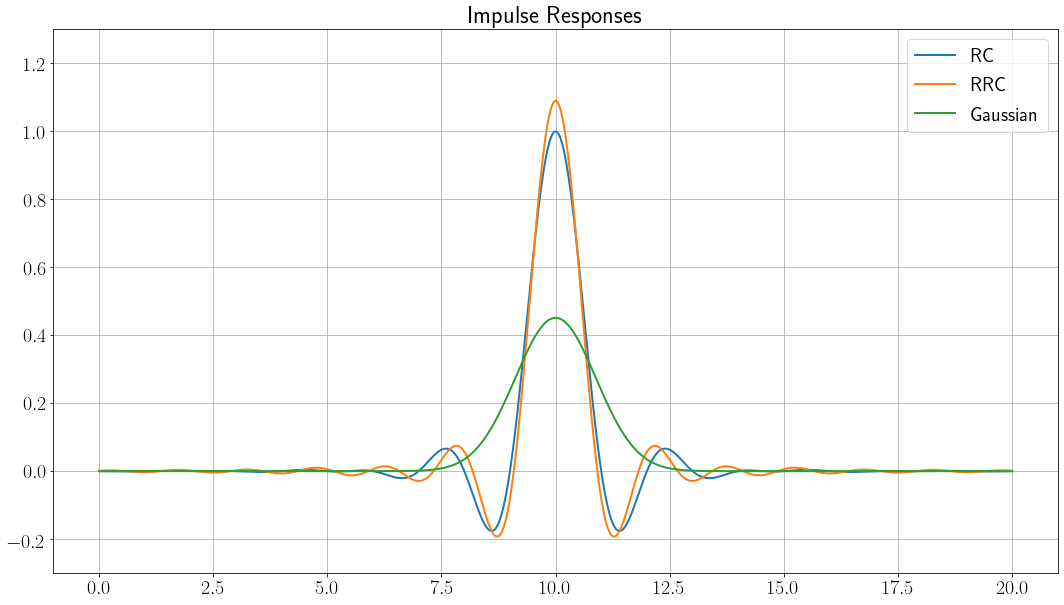

In [4]:
# Tests

# parameters of the filters
r_rc = .33
r_rrc = .33
r_gaussian = 0.8

syms_per_filt = 10  # symbols per filter (plus minus in both directions)
K_filt = 2 * syms_per_filt * n_up + 1         # length of the fir filter

t_rc, rc = get_rc_ir( K_filt, r_rc, f_symbol, n_up )
t_rrc, rrc = get_rrc_ir( K_filt, r_rrc, f_symbol, n_up )
t_gaussian, gaussian = get_gaussian_ir( K_filt, r_gaussian, f_symbol, n_up )

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 10) )

plt.plot( t_rc, rc, linewidth=2.0, label='RC' )
plt.plot( t_rrc, rrc, linewidth=2.0, label='RRC' )
plt.plot( t_gaussian, gaussian, linewidth=2.0, label='Gaussian' )

plt.ylim( (-.3, 1.3 ) ) 
plt.grid( True )
plt.legend( loc='upper right' )
plt.title( 'Impulse Responses' )